#Öncelikle kullanacağım kütüphaneleri import ederek başlıyorum.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import tqdm
import random
from shutil import copyfile

##Veri setini bilgisayarımdan yüklemek yerine direkt olarak buraya indirilmesini istiyorum.

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  78.8M      0  0:00:09  0:00:09 --:--:-- 84.6M


##İndirilen zip dosyasını açıyorum

In [3]:
!unzip "/content/kagglecatsanddogs_5340.zip"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  i

##Şu anda colab içerisine PetImages adlı, verilerimizin olduğu klasörü indirdik.

In [4]:
os.listdir('/content/')


['.config',
 'kagglecatsanddogs_5340.zip',
 'CDLA-Permissive-2.0.pdf',
 'PetImages',
 'readme[1].txt',
 'sample_data']

##Cat ve Dog klasörlerinin eleman sayılarına (içerisindeki fotoğraflar) bakıyorum.

In [5]:
print("The number of Cat Images ", len(os.listdir('/content/PetImages/Cat')))
print("The number of Dog Images ", len(os.listdir('/content/PetImages/Dog')))

The number of Cat Images  12501
The number of Dog Images  12501


## Train ve test verilerimi koymak için klasörler oluşturuyorum.

In [6]:
try:
    os.mkdir('/content/data/')
    os.mkdir('/content/data/train')
    os.mkdir('/content/data/test')
    os.mkdir('/content/data/train/cat')
    os.mkdir('/content/data/train/dog')
    os.mkdir('/content/data/test/cat')
    os.mkdir('/content/data/test/dog')
except:
    print('error')

##Test ve train için görsellerimi oluşturduuğum klasörlere bölüyorum.

In [7]:
def split_data(source, training, testing, split_size):
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(f'{filename} is corrupt or empty')
        
    training_length = int(len(files)* split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[:training_length]
    testing_set = shuffled_set[training_length:]
    
    for filename in training_set:
        this_file = source + filename
        dest = training + filename
        copyfile(this_file, dest)
    
    for filename in testing_set:
        this_file = source + filename
        dest = testing + filename
        copyfile(this_file, dest)

cat_src_dir = '/content/PetImages/Cat/'
dog_src_dir = '/content/PetImages/Dog/'
training_cat_dir = '/content/data/train/cat/'
training_dog_dir = '/content/data/train/dog/'
testing_cat_dir = '/content/data/test/cat/'
testing_dog_dir = '/content/data/test/dog/'

split_size = 0.9

split_data(cat_src_dir, training_cat_dir, testing_cat_dir, split_size)
split_data(dog_src_dir, training_dog_dir, testing_dog_dir, split_size)

666.jpg is corrupt or empty
11702.jpg is corrupt or empty


##Evet. Test için yaklaşık 22500 görsel ayırdık.

In [8]:
print("The number of Cat Test Images ", len(os.listdir('/content/data/train/cat/')))
print("The number of Dog Test Images ", len(os.listdir('/content/data/train/dog/')))

The number of Cat Test Images  11250
The number of Dog Test Images  11250


##Model için gerekli parametreleri önceden belirliyorum.

In [9]:
BATCH_SIZE = 32
IMAGE_SHAPE = 128

In [10]:
TRAIN_DIR='/content/data/train'
VALID_DIR='/content/data/test'

In [11]:
# make data generators
train_generator = ImageDataGenerator(rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255)
train_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


##Ben bu proje için mobilenet modelini kullanacağım. Bu yüüzden model keras içerisinden projeme çağırıyorum ve bir değişkende tutuyorum.

In [12]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
mobilenet_model.trainable = False # freeze convolutional layers

17235968/17225924 [==============================] - 0s 0us/step


##Model için hiperparametreleri ayarlıyorum.

In [13]:
dense_model = tf.keras.models.Sequential([
    Dense(units=1000, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

In [14]:
model2 = tf.keras.models.Sequential([
    mobilenet_model,
    dense_model
])

In [15]:
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

##Modelimi çalıştırıyorum.

In [17]:
EPOCHS = 5
train_data.reset()
valid_data.reset()
history = model2.fit_generator(
    train_data,
    steps_per_epoch=train_data.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=valid_data.n // BATCH_SIZE
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


703/703 [==============================] - 72s 102ms/step - loss: 0.0769 - accuracy: 0.9699 - val_loss: 0.0620 - val_accuracy: 0.9744
Epoch 2/5
703/703 [==============================] - 71s 100ms/step - loss: 0.0678 - accuracy: 0.9747 - val_loss: 0.1335 - val_accuracy: 0.9423
Epoch 3/5
703/703 [==============================] - 72s 102ms/step - loss: 0.0642 - accuracy: 0.9763 - val_loss: 0.0603 - val_accuracy: 0.9768
Epoch 4/5
703/703 [==============================] - 71s 101ms/step - loss: 0.0615 - accuracy: 0.9781 - val_loss: 0.0622 - val_accuracy: 0.9760
Epoch 5/5
703/703 [==============================] - 71s 100ms/step - loss: 0.0532 - accuracy: 0.9800 - val_loss: 0.0620 - val_accuracy: 0.9764


##Loss ve accuracy değerlerimi kontrol ediyorum.

In [18]:
print("Train_loss =", history.history['loss'][-1])
print("Train_accuracy =", history.history['accuracy'][-1])
print("Validation_loss =", history.history['val_loss'][-1])
print("Validation_accuracy=", history.history['val_accuracy'][-1])

Train_loss = 0.053221628069877625
Train_accuracy = 0.9800142645835876
Validation_loss = 0.06196916848421097
Validation_accuracy= 0.9763621687889099


##Daha okunaklı olması için görselleştirme tekniklerinden faydalanıyorum.

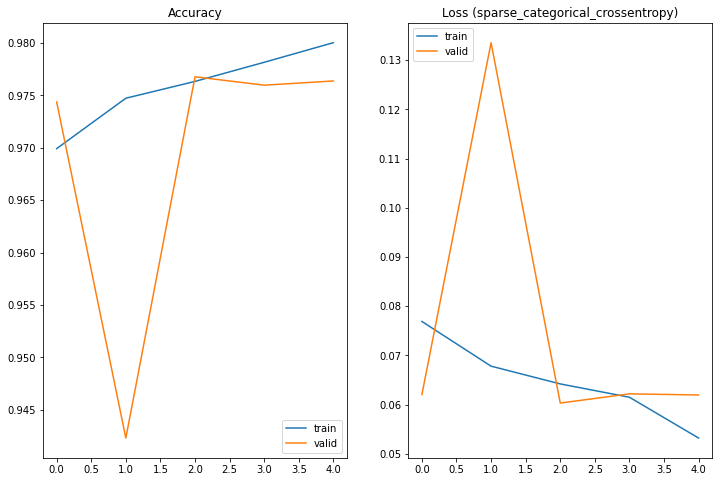

In [19]:
def show_graphs(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend(loc='upper left')
    plt.title('Loss (sparse_categorical_crossentropy)')

    plt.show()
show_graphs(history)


##Modelimi ufak bir teste tabii tutmak için veriler içerisinden rastgele örnek bir set oluşturuyorum.

In [20]:
IMAGE_SHAPE = 224
example_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
example_x, example_y = example_data.next()
example_classes = list(example_data.class_indices.keys())
example_y_classes = [example_classes[int(i)] for i in example_y]

Found 22498 images belonging to 2 classes.


##Ve modelimi test ederken çıktı olarak yine görselleştirme tekniklerinden faydalanıyorum.

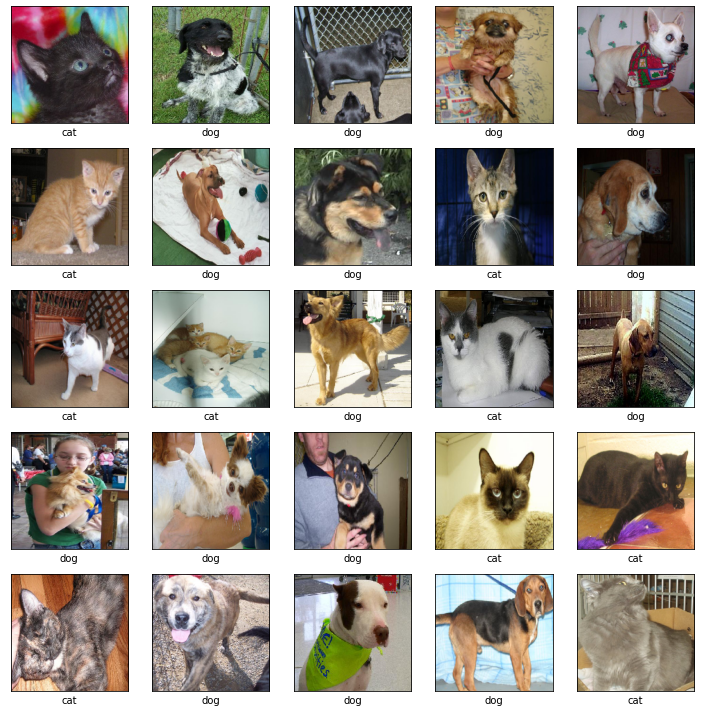

In [21]:
NUM_ROWS = 5
NUM_COLS = 5
NUM_IMAGES = NUM_COLS * NUM_ROWS
plt.figure(figsize=(2*NUM_COLS, 2*NUM_ROWS))
for i in range(NUM_IMAGES):
    k=random.sample(range(25000),1)
    plt.subplot(NUM_ROWS, NUM_COLS, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(example_x[i], cmap=plt.cm.binary)
    plt.xlabel('{}'.format(example_y_classes[i]))
plt.tight_layout()
plt.show()